In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('../')

In [3]:
import sys
sys.path.append('/home/njr61/rds/hpc-work/spurious-concepts/ConceptBottleneck')

In [4]:
import torch
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
import torch.nn as nn
import torch.optim as optim
import pickle
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap
import cv2
from copy import copy 
import itertools

In [5]:
from ConceptBottleneck.CUB.models import ModelXtoC, ModelOracleCtoY
from ConceptBottleneck.CUB.dataset import load_data

In [6]:
from src.images import *
from src.util import *
from src.models import *
from src.plot import *

## Set up dataset + model

In [7]:
dataset = 'CUB'
noisy=False
weight_decay = 0.0004
encoder_model='small3'
optimizer = 'sgd'

In [8]:
def get_log_folder(dataset,weight_decay,encoder_model,optimizer):
    if weight_decay == 0.0004 and encoder_model == 'inceptionv3':
        log_folder = f"results/{dataset}/joint"
    elif weight_decay == 0.0004:
        log_folder = f"results/{dataset}/joint_model_{encoder_model}"
    elif encoder_model == 'inceptionv3':
        log_folder = f"results/{dataset}/joint_wd_{weight_decay}"
    else:
        log_folder = f"results/{dataset}/joint_model_{encoder_model}_wd_{weight_decay}"
    if optimizer != 'sgd':
        log_folder += "_opt_{}".format(optimizer)
    
    log_folder += '/joint'
    
    return log_folder

In [9]:
dataset_name = "CUB"
data_dir = "../cem/cem/{}/preprocessed/".format(dataset_name)
data_dir

'../cem/cem/CUB/preprocessed/'

In [10]:
train_data_path = os.path.join(data_dir, 'train.pkl')
val_data_path = train_data_path.replace('train.pkl', 'val.pkl')

In [11]:
pretrained = True
freeze = False
use_aux = True
expand_dim = 0
three_class = False
use_attr = True
no_img = False
batch_size = 64
uncertain_labels = False
image_dir = 'images'
num_class_attr = 2
resampling = False

In [12]:
train_loader = load_data([train_data_path], use_attr, no_img, batch_size, uncertain_labels, image_dir=image_dir, 
                         n_class_attr=num_class_attr, resampling=resampling, path_transform=lambda path: "../cem/cem/"+path, is_training=False)
val_loader = load_data([val_data_path], use_attr, no_img=False, batch_size=64, image_dir=image_dir, n_class_attr=num_class_attr, path_transform=lambda path: "../cem/cem/"+path)

In [13]:
log_folder = get_log_folder(dataset_name,weight_decay,encoder_model,optimizer)
joint_location = "ConceptBottleneck/{}/best_model_42.pth".format(log_folder)
print(joint_location)
joint_model = torch.load(joint_location,map_location=torch.device('cpu'))
r = joint_model.eval()

ConceptBottleneck/results/CUB/joint_model_small3/joint/best_model_42.pth


## Plot the Dataset

In [14]:
train_pkl = pickle.load(open(train_data_path,"rb"))
val_pkl = pickle.load(open(val_data_path,"rb"))


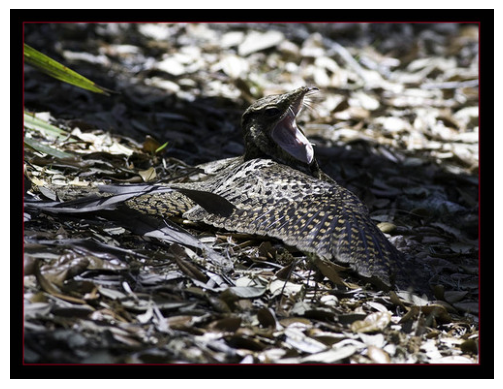

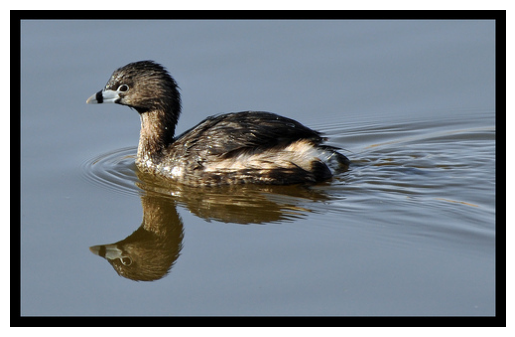

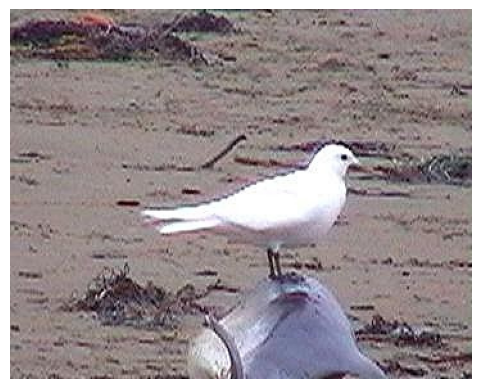

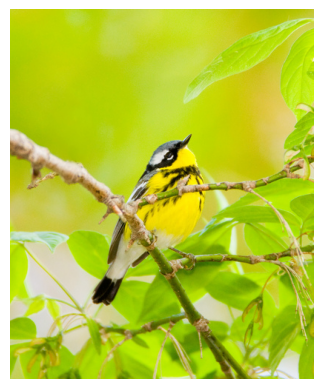

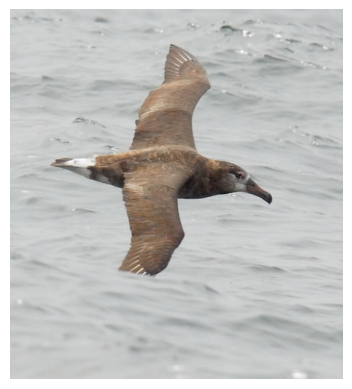

In [15]:
num_images_show = 5
for i in range(num_images_show):
    img_path = '../cem/cem/'+train_pkl[i]['img_path']
    image = Image.open(img_path)
    image_array = np.array(image)
    plt.figure()
    plt.imshow(image_array)
    plt.axis('off') 

In [21]:
val_images = []
val_y = []
val_c = []
for batch in val_loader:
    x, y, c = batch  
    val_images.append(x)
    val_y.append(y)
    val_c.append(torch.stack(c).T)
    break 
val_images = torch.cat(val_images, dim=0)
val_y = torch.cat(val_y,dim=0)
val_c = torch.cat(val_c,dim=0)

In [42]:
get_accuracy(joint_model,run_joint_model,train_loader), get_accuracy(joint_model,run_joint_model,val_loader)

: 

: 

In [37]:
get_concept_accuracy_by_concept(joint_model,run_joint_model,train_loader,sigmoid=True)

KeyboardInterrupt: 

## Saliency Maps

In [22]:
val_pkl[0]['attribute_label']

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0]

In [23]:
attributes = open("../cem/cem/CUB/metadata/attributes.txt").read().split("\n")

In [24]:
attributes[8]

'22 has_wing_color::white'

In [25]:
attribute_num = 8
dataset_num = 0

In [26]:
val_c[0][8]

tensor(1)

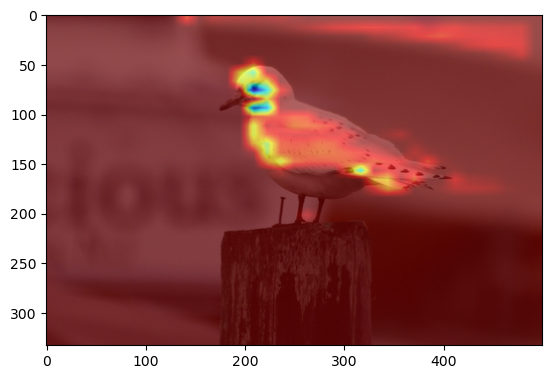

In [27]:
plot_gradcam(joint_model,run_joint_model,attribute_num,val_images,dataset_num,val_pkl)

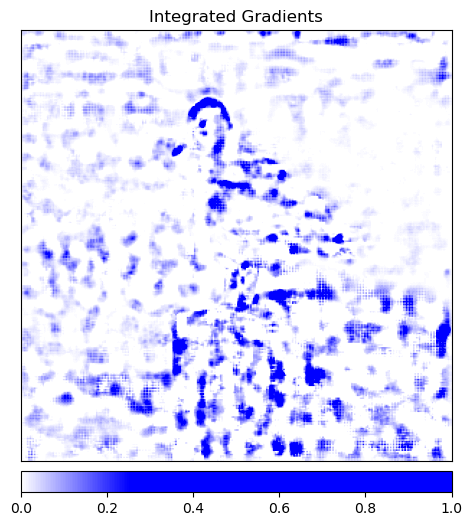

In [28]:
plot_integrated_gradients(joint_model,run_joint_model,attribute_num,val_images,dataset_num)

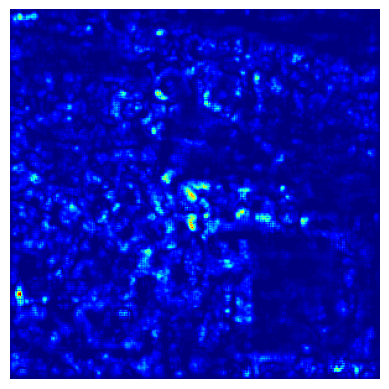

In [29]:
plot_saliency(joint_model,run_joint_model,attribute_num,val_images,dataset_num)

## Using Part Annotations

In [40]:
part_file = open("../cem/cem/CUB/metadata/parts/part_locs.txt").read().split("\n")